In [16]:
import torch
from emonet import EmoNet
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
random.seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoNet(n_expression=8)
model.load_state_dict(torch.load("D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\cfd_finetuned_emonet_100_epochs.pth"))
model.to(device)
model.eval()

### Preparing data for Angry Male (B and W)

In [3]:
#defining image transform
cfd_transform=transforms.Compose([ transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [4]:
#loading images from folders
def load_images(path):
    images_list=[]
    filenames=os.listdir(path)
    for file in filenames:
        img_path=os.path.join(path,file)
        image = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
        image = cfd_transform(image)
        images_list.append(image)
    return torch.stack(images_list)

In [5]:
path1="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\Black\Angry"
path2="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\White\Angry"  #change accordingly

b_imglist=load_images(path1)
w_imglist=load_images(path2)

print("Black Angry Images Shape:", b_imglist.shape)
print("White Angry Images Shape:", w_imglist.shape)

#we've loaded corresponding images

Black Angry Images Shape: torch.Size([35, 3, 256, 256])
White Angry Images Shape: torch.Size([35, 3, 256, 256])


### Analyzing for conv4, last conv layer before hourglass block

In [6]:
#observing last conv_layer before hourglass block, conv_4
black_feature_maps_dict = {}
def hook_fn(module, input, output):
    black_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [7]:
#observing last conv_layer before hourglass block, conv_4
white_feature_maps_dict = {}
def hook_fn(module, input, output):
    white_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [8]:
#passing angry black male images through emonet
black_feature_maps=[]
white_feature_maps=[]

with torch.no_grad():
    for i in range(b_imglist.shape[0]):
        image = b_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        black_feature_maps.append(black_feature_maps_dict["conv4"])

In [9]:
#we reset the dictionary to ensure new feature maps are added to white dictionary
feature_maps_dict={}

with torch.no_grad():
    for i in range(w_imglist.shape[0]):
        image = w_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        white_feature_maps.append(white_feature_maps_dict["conv4"]) 

In [10]:
wfm_tensor=torch.stack(white_feature_maps)
bfm_tensor=torch.stack(black_feature_maps)

In [11]:
wfm_tensor.shape

torch.Size([35, 1, 256, 64, 64])

In [12]:
black_mean_activation = bfm_tensor.mean(dim=0) 
white_mean_activation = wfm_tensor.mean(dim=0) 

activation_difference = black_mean_activation - white_mean_activation

#averaging activations of feature maps for all images of black and white, and taking their absolute difference.

print("Black Mean Activation Shape:", black_mean_activation.shape)
print("White Mean Activation Shape:", white_mean_activation.shape)
print("Activation Difference Shape:", activation_difference.shape)

Black Mean Activation Shape: torch.Size([1, 256, 64, 64])
White Mean Activation Shape: torch.Size([1, 256, 64, 64])
Activation Difference Shape: torch.Size([1, 256, 64, 64])


In [13]:
black_mean_activation = black_mean_activation.squeeze(0).cpu().detach().numpy()  
white_mean_activation = white_mean_activation.squeeze(0).cpu().detach().numpy()  
activation_difference = activation_difference.squeeze(0).cpu().detach().numpy()  

In [14]:
"""feature_map_index = [21, 103, 116, 81, 178]
fig, axes = plt.subplots(len(feature_map_index), 3, figsize=(60, 60))

for i, index in enumerate(feature_map_index):
    black_activation_map = black_mean_activation[index]
    white_activation_map = white_mean_activation[index]
    difference_map = activation_difference[index]

    axes[i, 0].imshow(black_activation_map, cmap='jet')
    axes[i, 0].set_title(f"black activation for feature {index}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(white_activation_map, cmap='jet')
    axes[i, 1].set_title(f"white activation for feature {index}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(difference_map, cmap='bwr', vmin=-np.max(np.abs(difference_map)), vmax=np.max(np.abs(difference_map)))
    axes[i, 2].set_title(f"activation difference for feature {index}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()"""


'feature_map_index = [21, 103, 116, 81, 178]\nfig, axes = plt.subplots(len(feature_map_index), 3, figsize=(60, 60))\n\nfor i, index in enumerate(feature_map_index):\n    black_activation_map = black_mean_activation[index]\n    white_activation_map = white_mean_activation[index]\n    difference_map = activation_difference[index]\n\n    axes[i, 0].imshow(black_activation_map, cmap=\'jet\')\n    axes[i, 0].set_title(f"black activation for feature {index}")\n    axes[i, 0].axis("off")\n\n    axes[i, 1].imshow(white_activation_map, cmap=\'jet\')\n    axes[i, 1].set_title(f"white activation for feature {index}")\n    axes[i, 1].axis("off")\n\n    axes[i, 2].imshow(difference_map, cmap=\'bwr\', vmin=-np.max(np.abs(difference_map)), vmax=np.max(np.abs(difference_map)))\n    axes[i, 2].set_title(f"activation difference for feature {index}")\n    axes[i, 2].axis("off")\n\nplt.tight_layout()\nplt.show()'

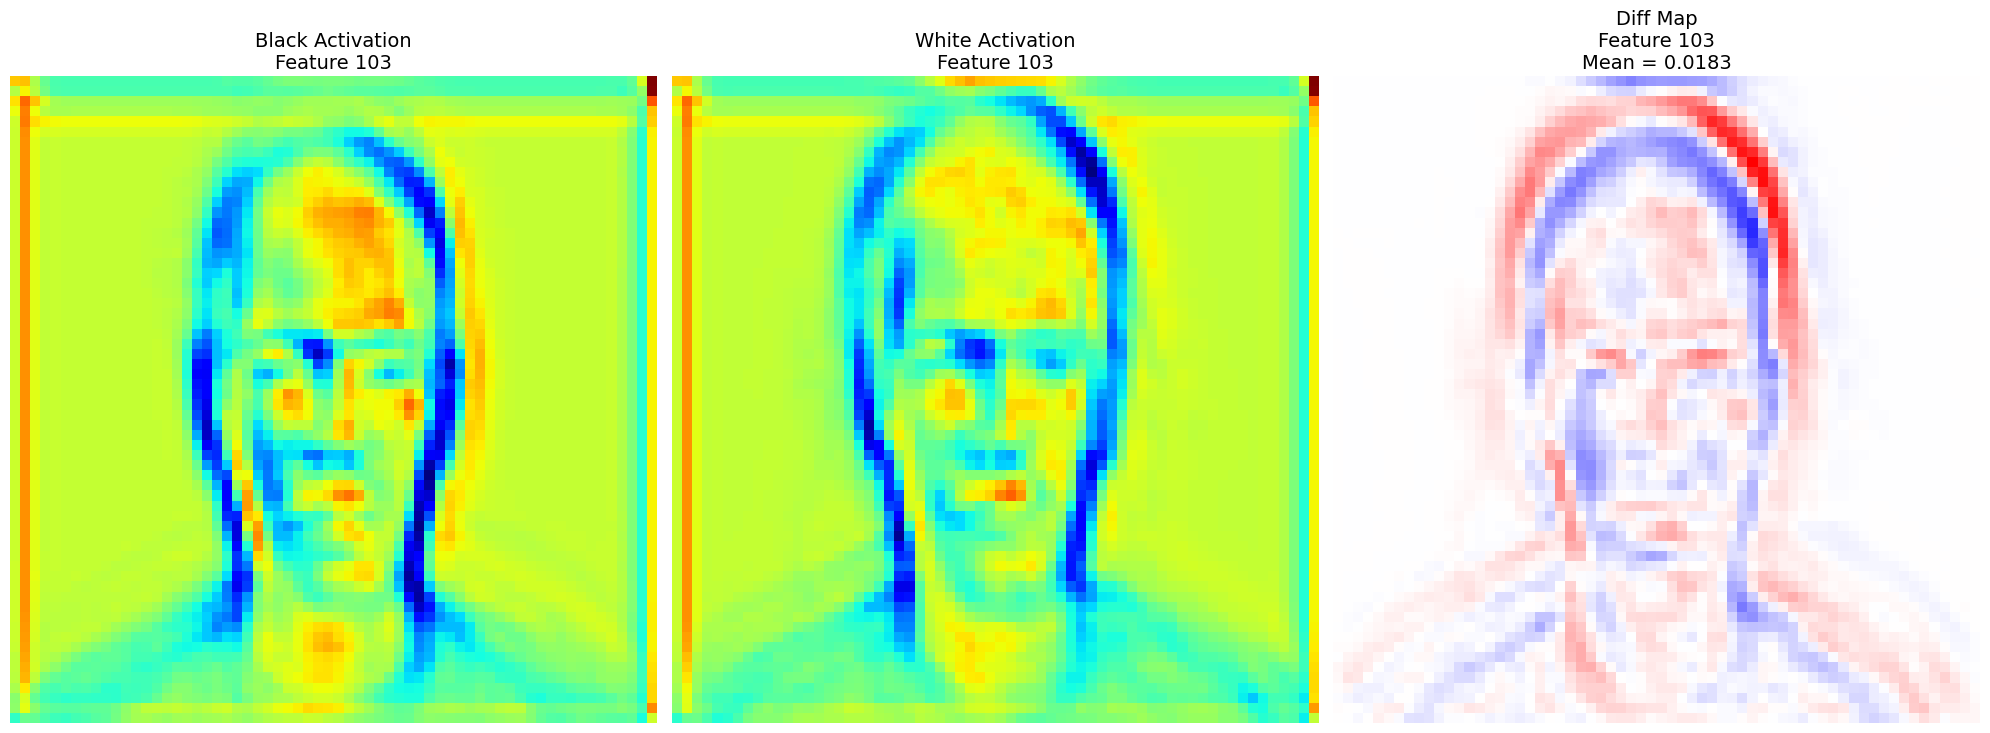

In [15]:
feature_map_index = [103]
fig, axes = plt.subplots(len(feature_map_index), 3, figsize=(20, 20))

if len(feature_map_index) == 1:
    axes = axes.reshape(1, 3)

for i, index in enumerate(feature_map_index):
    black_activation_map = black_mean_activation[index]
    white_activation_map = white_mean_activation[index]
    difference_map = activation_difference[index]

    signed_diff = np.mean(difference_map)

    axes[i, 0].imshow(black_activation_map, cmap='jet')
    axes[i, 0].set_title(f"Black Activation\nFeature {index}", fontsize=14)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(white_activation_map, cmap='jet')
    axes[i, 1].set_title(f"White Activation\nFeature {index}", fontsize=14)
    axes[i, 1].axis("off")

    axes[i, 2].imshow(difference_map, cmap='bwr',
                     vmin=-np.max(np.abs(difference_map)),
                     vmax=np.max(np.abs(difference_map)))
    axes[i, 2].set_title(f"Diff Map\nFeature {index}\nMean = {signed_diff:.4f}", fontsize=14)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [17]:
def get_conv4_activations(image_tensor, model, suppressed_indices=None):
    activations = {}

    def conv4_hook(module, input, output):
        if suppressed_indices is not None:
            output = output.clone()
            output[:, suppressed_indices, :, :] = 0
        activations["conv4"] = output

    handle = model.conv4.register_forward_hook(conv4_hook)

    with torch.no_grad():
        _ = model(image_tensor.to(next(model.parameters()).device))

    handle.remove()
    return activations["conv4"].squeeze(0).cpu() 

def visualize_activation_difference(image_tensor, model, suppressed_indices, title="Activation Diff (Pre - Post)", figsize=(6, 6)):
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post 

    diff_map = A_diff.sum(dim=0)
    diff_map = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-5)

    resized_diff = F.interpolate(
        diff_map.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False
    ).squeeze()

    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(orig)
    plt.imshow(resized_diff, cmap='bwr', alpha=0.5)
    plt.axis("off")
    plt.title(title)
    plt.show()

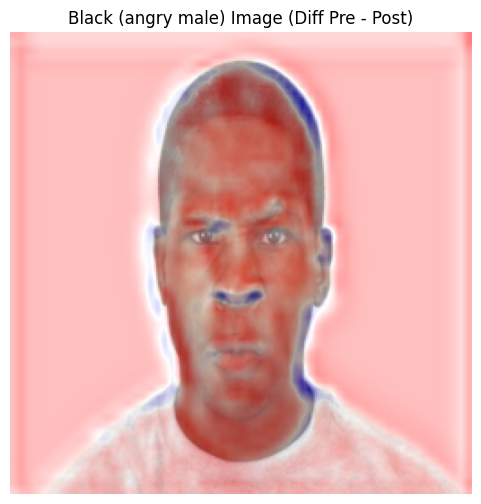

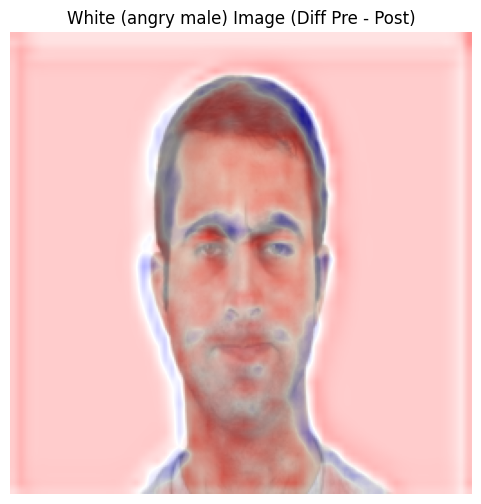

In [18]:
suppressed_indices = [103]
visualize_activation_difference(b_imglist[0].unsqueeze(0), model, suppressed_indices, title="Black (angry male) Image (Diff Pre - Post)")
visualize_activation_difference(w_imglist[0].unsqueeze(0), model, suppressed_indices, title="White (angry male) Image (Diff Pre - Post)")

In [ ]:
def visualize_pre_post_diff(image_tensor, model, suppressed_indices, figsize=(18, 6)):
    # Get activations
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post  # [C, H, W]

    # Sum across channels
    pre_map = A_pre.sum(dim=0)
    post_map = A_post.sum(dim=0)
    diff_map = A_diff.sum(dim=0)

    # Normalize each map individually (retain signed values for diff_map)
    pre_map_norm = (pre_map - pre_map.min()) / (pre_map.max() - pre_map.min() + 1e-5)
    post_map_norm = (post_map - post_map.min()) / (post_map.max() - post_map.min() + 1e-5)

    # For signed diff map, normalize but preserve sign
    max_abs = diff_map.abs().max() + 1e-5
    diff_map_norm = diff_map / max_abs  # Now in range [-1, 1]

    # Resize to match image size
    pre_map_resized = F.interpolate(pre_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    post_map_resized = F.interpolate(post_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    diff_map_resized = F.interpolate(diff_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()

    # Prepare original image
    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()  # [H, W, 3]
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    # Plot all three
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    axs[0].imshow(orig)
    axs[0].imshow(pre_map_resized, cmap='jet', alpha=0.5)
    axs[0].set_title(f"Pre-Suppression")
    axs[0].axis("off")

    axs[1].imshow(orig)
    axs[1].imshow(post_map_resized, cmap='jet', alpha=0.5)
    axs[1].set_title(f"Post-Suppression")
    axs[1].axis("off")

    im = axs[2].imshow(orig)
    im = axs[2].imshow(diff_map_resized, cmap='bwr', alpha=0.5)
    axs[2].set_title(f"(Pre - Post)")
    axs[2].axis("off")


    plt.tight_layout()
    plt.show()


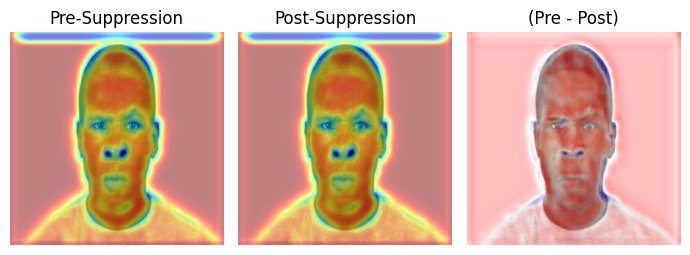

In [23]:
visualize_pre_post_diff(
    image_tensor=b_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)

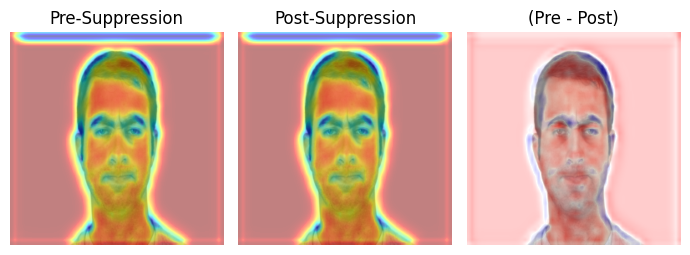

In [22]:
visualize_pre_post_diff(
    image_tensor=w_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)